In [63]:
import pandas as pd
test2024 = pd.read_csv("../validation/testing2024manual.csv")
prediction_mapping = pd.read_csv("../data/prediction_mapping.csv")
merged = test2024.merge(prediction_mapping, on="ID")
filtered = merged[merged.groupby("rm_id")["predicted_weight"].transform("sum") > 0]
agg_df = filtered.groupby("rm_id", as_index=False).agg({
    "predicted_weight": "max"
})

In [64]:
used_rm_ids = set(agg_df["rm_id"])

receivals = pd.read_csv("../data_cleaned/orders_with_receivals_detailed.csv")
receivals_filtered = receivals[receivals["rm_id"].isin(used_rm_ids)]
selected = receivals_filtered[["rm_id", "date_arrival", "net_weight"]]

In [65]:
# --- TFT Model Training: Use all data for training, no validation split ---
import pandas as pd
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet, GroupNormalizer, QuantileLoss
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch as pl

# Load historical data
df_hist = receivals_filtered[["rm_id", "date_arrival", "net_weight"]].copy()
df_hist["date_arrival"] = pd.to_datetime(df_hist["date_arrival"])
if hasattr(df_hist["date_arrival"].dt, "tz") and df_hist["date_arrival"].dt.tz is not None:
    df_hist["date_arrival"] = df_hist["date_arrival"].dt.tz_localize(None)
df_hist["rm_id"] = df_hist["rm_id"].astype(str)
df_hist["time_idx"] = (df_hist["date_arrival"] - df_hist["date_arrival"].min()).dt.days

# Use all data for training
train_data = df_hist.copy()

max_encoder_length = 60
max_prediction_length = 30
batch_size = 64

training = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="net_weight",
    group_ids=["rm_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["rm_id"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["net_weight"],
    target_normalizer=GroupNormalizer(groups=["rm_id"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=0,
    reduce_on_plateau_patience=4,
)

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="auto",
    gradient_clip_val=0.1,
    limit_train_batches=30,
    callbacks=[LearningRateMonitor(), EarlyStopping(monitor="train_loss", patience=3)],
    logger=TensorBoardLogger("lightning_logs"),
    enable_checkpointing=True,
)

trainer.fit(tft, train_dataloaders=train_dataloader)

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:1850: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 4 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__rm_id': '3581.0'}, {'__group_id__rm_id': '3621.0'}, {'__group_id__rm_id': '4081.0'}, {'__group_id__rm_id': '4161.0'}]
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already sav

Epoch 1:   0%|          | 0/30 [00:00<?, ?it/s, v_num=25, train_loss_step=2.11e+3, train_loss_epoch=2.42e+3]         

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\lightning\pytorch\loops\training_epoch_loop.py:492: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 6: 100%|██████████| 30/30 [00:18<00:00,  1.62it/s, v_num=25, train_loss_step=2.64e+3, train_loss_epoch=2.24e+3]


In [66]:
# Make predictions for 2025 using the trained TFT model
import pandas as pd
import numpy as np
from pytorch_forecasting import NBeats, TimeSeriesDataSet

# Get the last available data point for each rm_id
last_data = df_hist.groupby("rm_id").tail(max_encoder_length).reset_index(drop=True)

# Define the prediction period (2025-01-01 to 2025-05-31)
prediction_start = pd.Timestamp("2025-01-01")
prediction_end = pd.Timestamp("2025-05-31")

# Convert to time_idx based on the historical data's date range
base_date = df_hist["date_arrival"].min()
start_time_idx = (prediction_start - base_date).days
end_time_idx = (prediction_end - base_date).days

print(f"Historical data time_idx range: 0 to {df_hist['time_idx'].max()}")
print(f"Prediction time_idx range: {start_time_idx} to {end_time_idx}")

# Create future time steps for the prediction period
future_time_steps = list(range(start_time_idx, end_time_idx + 1))

# Prepare future data for prediction - but limit to reasonable batch size
future_data = []
for rm_id in df_hist["rm_id"].unique():
    for future_time in future_time_steps[:max_prediction_length]:  # Limit to model's max prediction length
        future_data.append({
            "rm_id": rm_id,
            "time_idx": future_time,
            "net_weight": 0,  # Placeholder - will be predicted
        })

future_df = pd.DataFrame(future_data)

# Combine historical data with future data for prediction
prediction_data = pd.concat([df_hist, future_df]).reset_index(drop=True)
prediction_data = prediction_data.sort_values(["rm_id", "time_idx"]).reset_index(drop=True)

print(f"Combined dataset shape: {prediction_data.shape}")
print(f"Time_idx range in combined data: {prediction_data['time_idx'].min()} to {prediction_data['time_idx'].max()}")

# Create prediction dataset
try:
    prediction_dataset = TimeSeriesDataSet.from_dataset(
        training, 
        prediction_data, 
        predict=True, 
        stop_randomization=True
    )
    
    # Create prediction dataloader
    pred_dataloader = prediction_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
    
    # Make predictions
    print("Making TFT predictions...")
    predictions = tft.predict(pred_dataloader, mode="prediction", return_x=True)
    
    print("TFT predictions completed.")
    print(f"Prediction shape: {predictions[0].shape}")
    
    # Process predictions to create simulated receivals
    predicted_values = predictions[0].cpu().numpy()
    
    # Create results dataframe
    results = []
    
    # Get the prediction data that corresponds to the future period
    future_prediction_data = prediction_data[prediction_data["time_idx"] >= start_time_idx].copy()
    
    prediction_idx = 0
    for _, row in future_prediction_data.iterrows():
        if prediction_idx < len(predicted_values):
            # Convert time_idx back to date
            predicted_date = base_date + pd.Timedelta(days=int(row["time_idx"]))
            
            # Get the predicted value (handle different output formats)
            if predicted_values.ndim == 3:  # (batch, time, quantiles)
                pred_value = predicted_values[prediction_idx, 0, 3]  # Middle quantile (median)
            elif predicted_values.ndim == 2:  # (batch, quantiles)
                pred_value = predicted_values[prediction_idx, 3]  # Middle quantile (median)
            else:
                pred_value = predicted_values[prediction_idx]
            
            # Only include positive predictions
            if pred_value > 0:
                results.append({
                    "rm_id": row["rm_id"],
                    "time_idx": row["time_idx"],
                    "date_arrival": predicted_date,
                    "net_weight": pred_value,
                })
            
            prediction_idx += 1
    
    # Extend predictions for the full period if we only got a limited window
    if len(results) > 0:
        simulated_df = pd.DataFrame(results)
        
        # If we only have predictions for the first 30 days, extend them with patterns
        if len(future_time_steps) > max_prediction_length:
            print(f"Extending TFT predictions from {max_prediction_length} days to {len(future_time_steps)} days...")
            
            # Calculate patterns from the predicted period
            extended_results = results.copy()
            
            for rm_id in df_hist["rm_id"].unique():
                rm_predictions = [r for r in results if r["rm_id"] == rm_id]
                if rm_predictions:
                    # Calculate average and trend from initial predictions
                    weights = [r["net_weight"] for r in rm_predictions]
                    avg_weight = np.mean(weights)
                    
                    # Extend to remaining days with decay
                    for time_idx in future_time_steps[max_prediction_length:]:
                        pred_date = base_date + pd.Timedelta(days=int(time_idx))
                        
                        # Apply gradual decay (reduce predictions over time)
                        days_beyond = time_idx - future_time_steps[max_prediction_length-1]
                        decay_factor = max(0.1, 1.0 / (1.0 + days_beyond * 0.02))  # 2% decay per day
                        
                        pred_weight = avg_weight * decay_factor * np.random.normal(1.0, 0.05)  # 5% noise
                        
                        if pred_weight > 0:
                            extended_results.append({
                                "rm_id": rm_id,
                                "time_idx": time_idx,
                                "date_arrival": pred_date,
                                "net_weight": pred_weight,
                            })
            
            simulated_df = pd.DataFrame(extended_results)
    else:
        simulated_df = pd.DataFrame()
    
    print("TFT-based forecasting complete.")
    print(f"Total simulated receivals for 2025: {len(simulated_df)}")
    if len(simulated_df) > 0:
        print(f"Date range: {simulated_df['date_arrival'].min()} to {simulated_df['date_arrival'].max()}")
        print(f"Weight range: {simulated_df['net_weight'].min():.2f} to {simulated_df['net_weight'].max():.2f}")
        print(simulated_df.head())
        
        # Save the results
        simulated_df.to_csv("simulated_receivals_2025.csv", index=False)
        print("Results saved to simulated_receivals_2025.csv")
    else:
        raise Exception("No predictions generated from TFT model")
        
except Exception as e:
    print(f"Error during TFT prediction: {str(e)}")
    print("Falling back to N-BEATS model for more accurate time series forecasting...")
    
    # N-BEATS FALLBACK - Much better than simple averages!
    try:
        # Prepare data for N-BEATS (simpler requirements than TFT)
        nbeats_encoder_length = 30  # Shorter than TFT
        nbeats_prediction_length = 30
        
        # Create N-BEATS dataset
        nbeats_training = TimeSeriesDataSet(
            df_hist,
            time_idx="time_idx",
            target="net_weight",
            group_ids=["rm_id"],
            min_encoder_length=nbeats_encoder_length,
            max_encoder_length=nbeats_encoder_length,
            min_prediction_length=1,
            max_prediction_length=nbeats_prediction_length,
            static_categoricals=["rm_id"],
            time_varying_known_reals=["time_idx"],
            time_varying_unknown_reals=["net_weight"],
            add_relative_time_idx=True,
            allow_missing_timesteps=True,
        )
        
        nbeats_dataloader = nbeats_training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
        
        # Create and train N-BEATS model
        print("Training N-BEATS model...")
        nbeats = NBeats.from_dataset(
            nbeats_training,
            learning_rate=0.02,
            log_interval=0,
            stack_types=["trend", "seasonality"],  # Focus on trend and seasonality
            num_blocks=[3, 3],
            num_block_layers=[4, 4],
            widths=[256, 256],
            sharing=[True, True],
        )
        
        nbeats_trainer = pl.Trainer(
            max_epochs=15,  # Faster training than TFT
            accelerator="auto",
            limit_train_batches=20,
            callbacks=[EarlyStopping(monitor="train_loss", patience=2)],
            enable_checkpointing=False,
            logger=False,
        )
        
        nbeats_trainer.fit(nbeats, train_dataloaders=nbeats_dataloader)
        
        # Prepare prediction data for N-BEATS
        nbeats_future_data = []
        for rm_id in df_hist["rm_id"].unique():
            for future_time in future_time_steps[:nbeats_prediction_length]:
                nbeats_future_data.append({
                    "rm_id": rm_id,
                    "time_idx": future_time,
                    "net_weight": 0,
                })
        
        nbeats_future_df = pd.DataFrame(nbeats_future_data)
        nbeats_prediction_data = pd.concat([df_hist, nbeats_future_df]).reset_index(drop=True)
        nbeats_prediction_data = nbeats_prediction_data.sort_values(["rm_id", "time_idx"]).reset_index(drop=True)
        
        # Create N-BEATS prediction dataset
        nbeats_pred_dataset = TimeSeriesDataSet.from_dataset(
            nbeats_training, 
            nbeats_prediction_data, 
            predict=True, 
            stop_randomization=True
        )
        
        nbeats_pred_dataloader = nbeats_pred_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
        
        # Make N-BEATS predictions
        print("Making N-BEATS predictions...")
        nbeats_predictions = nbeats.predict(nbeats_pred_dataloader, mode="prediction", return_x=True)
        nbeats_predicted_values = nbeats_predictions[0].cpu().numpy()
        
        print(f"N-BEATS prediction shape: {nbeats_predicted_values.shape}")
        
        # Process N-BEATS predictions
        nbeats_results = []
        nbeats_future_pred_data = nbeats_prediction_data[nbeats_prediction_data["time_idx"] >= start_time_idx].copy()
        
        pred_idx = 0
        for _, row in nbeats_future_pred_data.iterrows():
            if pred_idx < len(nbeats_predicted_values):
                predicted_date = base_date + pd.Timedelta(days=int(row["time_idx"]))
                
                # Get predicted value
                if nbeats_predicted_values.ndim == 2:
                    pred_value = nbeats_predicted_values[pred_idx, 0]
                else:
                    pred_value = nbeats_predicted_values[pred_idx]
                
                if pred_value > 0:
                    nbeats_results.append({
                        "rm_id": row["rm_id"],
                        "time_idx": row["time_idx"],
                        "date_arrival": predicted_date,
                        "net_weight": pred_value,
                    })
                
                pred_idx += 1
        
        # Extend N-BEATS predictions for full period with realistic patterns
        if len(nbeats_results) > 0 and len(future_time_steps) > nbeats_prediction_length:
            print(f"Extending N-BEATS predictions to full period...")
            
            extended_nbeats = nbeats_results.copy()
            
            # Calculate historical seasonality and trends for each rm_id
            for rm_id in df_hist["rm_id"].unique():
                rm_hist = df_hist[df_hist["rm_id"] == rm_id].copy()
                rm_nbeats_pred = [r for r in nbeats_results if r["rm_id"] == rm_id]
                
                if len(rm_nbeats_pred) > 0 and len(rm_hist) > 0:
                    # Get trend from N-BEATS predictions
                    pred_weights = [r["net_weight"] for r in rm_nbeats_pred]
                    avg_pred_weight = np.mean(pred_weights)
                    
                    # Calculate historical total for realistic scaling
                    hist_2024 = rm_hist[rm_hist["date_arrival"].dt.year == 2024]
                    if len(hist_2024) > 0:
                        total_2024 = hist_2024["net_weight"].sum()
                        # Scale predictions to be more realistic (e.g., similar to 2024 levels)
                        scale_factor = min(1.0, total_2024 / (avg_pred_weight * len(future_time_steps)))
                    else:
                        scale_factor = 0.5  # Conservative scaling
                    
                    # Extend with decay and seasonality
                    for time_idx in future_time_steps[nbeats_prediction_length:]:
                        pred_date = base_date + pd.Timedelta(days=int(time_idx))
                        
                        # Seasonal component (weekly pattern)
                        day_of_week = pred_date.dayofweek
                        seasonal_factor = 0.8 + 0.4 * np.sin(2 * np.pi * day_of_week / 7)
                        
                        # Time decay
                        days_beyond = time_idx - future_time_steps[nbeats_prediction_length-1]
                        decay_factor = max(0.05, np.exp(-days_beyond * 0.01))  # Exponential decay
                        
                        pred_weight = avg_pred_weight * scale_factor * seasonal_factor * decay_factor
                        
                        # Add some randomness but keep it realistic
                        pred_weight *= np.random.uniform(0.7, 1.3)
                        
                        if pred_weight > 0.1:  # Only meaningful predictions
                            extended_nbeats.append({
                                "rm_id": rm_id,
                                "time_idx": time_idx,
                                "date_arrival": pred_date,
                                "net_weight": pred_weight,
                            })
            
            simulated_df = pd.DataFrame(extended_nbeats)
        else:
            simulated_df = pd.DataFrame(nbeats_results)
        
        print("N-BEATS forecasting complete!")
        
    except Exception as nbeats_error:
        print(f"N-BEATS also failed: {str(nbeats_error)}")
        print("Using conservative historical scaling as final fallback...")
        
        # CONSERVATIVE FALLBACK: Scale historical totals
        fallback_results = []
        
        for rm_id in df_hist["rm_id"].unique():
            rm_hist = df_hist[df_hist["rm_id"] == rm_id]
            
            # Get 2024 total (most recent full year)
            hist_2024 = rm_hist[rm_hist["date_arrival"].dt.year == 2024]
            if len(hist_2024) > 0:
                total_2024 = hist_2024["net_weight"].sum()
                num_deliveries_2024 = len(hist_2024)
                
                # Conservative prediction: 60-80% of 2024 levels
                conservative_factor = np.random.uniform(0.6, 0.8)
                expected_total_2025 = total_2024 * conservative_factor
                
                # Distribute over fewer deliveries (not every day!)
                expected_deliveries = max(1, int(num_deliveries_2024 * conservative_factor))
                
                if expected_deliveries > 0 and expected_total_2025 > 0:
                    avg_delivery_weight = expected_total_2025 / expected_deliveries
                    
                    # Random delivery dates
                    delivery_dates = np.random.choice(
                        len(future_time_steps), 
                        size=min(expected_deliveries, len(future_time_steps)), 
                        replace=False
                    )
                    
                    for date_idx in delivery_dates:
                        time_idx = future_time_steps[date_idx]
                        pred_date = base_date + pd.Timedelta(days=int(time_idx))
                        
                        # Vary delivery weights
                        delivery_weight = avg_delivery_weight * np.random.uniform(0.7, 1.3)
                        
                        fallback_results.append({
                            "rm_id": rm_id,
                            "time_idx": time_idx,
                            "date_arrival": pred_date,
                            "net_weight": delivery_weight,
                        })
        
        simulated_df = pd.DataFrame(fallback_results)
        print(f"Conservative fallback generated: {len(simulated_df)} deliveries")

    # Final output
    if len(simulated_df) > 0:
        print(f"Total simulated receivals for 2025: {len(simulated_df)}")
        print(f"Date range: {simulated_df['date_arrival'].min()} to {simulated_df['date_arrival'].max()}")
        print(f"Weight range: {simulated_df['net_weight'].min():.2f} to {simulated_df['net_weight'].max():.2f}")
        
        # Show totals by rm_id for verification
        totals_by_rm = simulated_df.groupby("rm_id")["net_weight"].sum().sort_values(ascending=False)
        print(f"\nTop predicted totals by rm_id:")
        print(totals_by_rm.head(10))
        
        simulated_df.to_csv("simulated_receivals_2025.csv", index=False)
        print("Results saved to simulated_receivals_2025.csv")
    else:
        print("No predictions generated!")

Historical data time_idx range: 0 to 4784
Prediction time_idx range: 4796 to 4946
Combined dataset shape: (61824, 4)
Time_idx range in combined data: 0 to 4825
Error during TFT prediction: filters should not remove entries all entries - check encoder/decoder lengths and lags
Falling back to N-BEATS model for more accurate time series forecasting...


C:\Users\david\AppData\Roaming\Python\Python312\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:1850: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 46 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__rm_id': '2124.0'}, {'__group_id__rm_id': '2125.0'}, {'__group_id__rm_id': '2129.0'}, {'__group_id__rm_id': '2130.0'}, {'__group_id__rm_id': '2131.0'}, {'__group_id__rm_id': '2132.0'}, {'__group_id__rm_id': '2133.0'}, {'__group_id__rm_id': '2134.0'}, {'__group_id__rm_id': '2135.0'}, {'__group_id__rm_id': '2140.0'}]
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:1850: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 5 series/groups which theref

Training N-BEATS model...
N-BEATS also failed: only fixed prediction length is allowed, but max_prediction_length != min_prediction_length
Using conservative historical scaling as final fallback...
Conservative fallback generated: 2558 deliveries
Total simulated receivals for 2025: 2558
Date range: 2024-12-31 10:15:00 to 2025-05-30 10:15:00
Weight range: 1210.79 to 37877.24

Top predicted totals by rm_id:
rm_id
3125.0    3.778388e+06
3282.0    3.222582e+06
3124.0    3.130660e+06
3123.0    3.106449e+06
3122.0    3.104981e+06
3126.0    2.863320e+06
2130.0    2.583381e+06
3781.0    2.495542e+06
3865.0    1.707734e+06
3901.0    1.387153e+06
Name: net_weight, dtype: float64
Results saved to simulated_receivals_2025.csv


In [67]:
# Verify predictions are realistic by comparing to 2024 Jan–May actuals
print("\n=== PREDICTION VERIFICATION (Jan–May) ===")

if len(simulated_df) > 0:
    jan_may_mask_2024 = (df_hist["date_arrival"] >= pd.Timestamp("2024-01-01")) & (df_hist["date_arrival"] <= pd.Timestamp("2024-05-31"))
    hist_2024_janm_total = df_hist.loc[jan_may_mask_2024].groupby("rm_id")["net_weight"].sum()

    jan_may_mask_2025 = (simulated_df["date_arrival"] >= pd.Timestamp("2025-01-01")) & (simulated_df["date_arrival"] <= pd.Timestamp("2025-05-31"))
    pred_2025_janm_total = simulated_df.loc[jan_may_mask_2025].groupby("rm_id")["net_weight"].sum()

    comparison = pd.DataFrame({
        "hist_2024_JanMay": hist_2024_janm_total,
        "pred_2025_JanMay": pred_2025_janm_total
    }).fillna(0)

    comparison["ratio_2025_to_2024_JanMay"] = comparison["pred_2025_JanMay"] / (comparison["hist_2024_JanMay"] + 1e-6)
    comparison = comparison.sort_values("pred_2025_JanMay", ascending=False)

    print("Comparison of 2025 Jan–May predictions vs 2024 Jan–May actual:")
    print("rm_id\t2024_JanMay\t2025_JanMay_pred\tratio")
    for rm_id, row in comparison.head(15).iterrows():
        print(f"{rm_id}\t{row['hist_2024_JanMay']:.0f}\t\t{row['pred_2025_JanMay']:.0f}\t\t{row['ratio_2025_to_2024_JanMay']:.2f}")

    over_predicted = comparison[comparison["ratio_2025_to_2024_JanMay"] > 1.5]
    if len(over_predicted) > 0:
        print(f"\nWarning: {len(over_predicted)} rm_ids predicted >1.5x their 2024 Jan–May levels:")
        print(over_predicted["ratio_2025_to_2024_JanMay"].head(10))

    under_predicted = comparison[comparison["ratio_2025_to_2024_JanMay"] < 0.3]
    if len(under_predicted) > 0:
        print(f"\nInfo: {len(under_predicted)} rm_ids predicted <30% of their 2024 Jan–May levels")

    print(f"\nOverall statistics (Jan–May):")
    print(f"- Average ratio: {comparison['ratio_2025_to_2024_JanMay'].mean():.2f}")
    print(f"- Median ratio: {comparison['ratio_2025_to_2024_JanMay'].median():.2f}")
    print(f"- Total 2024 Jan–May: {comparison['hist_2024_JanMay'].sum():.0f}")
    print(f"- Total 2025 Jan–May predicted: {comparison['pred_2025_JanMay'].sum():.0f}")
    print(f"- Overall ratio: {comparison['pred_2025_JanMay'].sum() / (comparison['hist_2024_JanMay'].sum() + 1e-6):.2f}")
else:
    print("No predictions to verify!")


=== PREDICTION VERIFICATION (Jan–May) ===
Comparison of 2025 Jan–May predictions vs 2024 Jan–May actual:
rm_id	2024_JanMay	2025_JanMay_pred	ratio
3125.0	3028260		3749358		1.24
3282.0	2373080		3222582		1.36
3124.0	2407820		3107952		1.29
3123.0	1782880		3087311		1.73
3122.0	2183320		3085562		1.41
3126.0	2998700		2845229		0.95
2130.0	3549704		2565912		0.72
3781.0	6528018		2479784		0.38
3865.0	5801072		1695823		0.29
3901.0	857880		1372317		1.60
2140.0	1046440		1309840		1.25
2134.0	612846		1200976		1.96
2135.0	494030		565365		1.14
2142.0	445868		540176		1.21
3265.0	576140		513893		0.89

rm_id
3123.0    1.731642
3901.0    1.599660
2134.0    1.959671
2131.0    2.056715
3362.0    4.022364
4222.0    5.176226
2144.0    1.711355
2145.0    1.799240
2741.0    1.971848
3421.0    1.934368
Name: ratio_2025_to_2024_JanMay, dtype: float64

Info: 1 rm_ids predicted <30% of their 2024 Jan–May levels

Overall statistics (Jan–May):
- Average ratio: 1.64
- Median ratio: 1.43
- Total 2024 Jan–May: 37542429
-

In [68]:
# Calibrate predictions: optional; if CALIBRATION_MODE='off', pass-through without caps/scaling
CALIBRATION_MODE = "off"  # options: 'off' | 'cap' | 'scale'
CAL_TOLERANCE = 1.05       # used only when mode is 'cap' or 'scale'

if len(simulated_df) > 0:
    if CALIBRATION_MODE == "off":
        # Write original predictions unchanged to canonical file
        simulated_df.to_csv("simulated_receivals_2025.csv", index=False)
        print("Calibration disabled: wrote original predictions to simulated_receivals_2025.csv")
    else:
        # Build 2024 Jan–May baseline
        jan_may_mask_2024 = (df_hist["date_arrival"] >= pd.Timestamp("2024-01-01")) & (df_hist["date_arrival"] <= pd.Timestamp("2024-05-31"))
        baseline_2024 = df_hist.loc[jan_may_mask_2024].groupby("rm_id")["net_weight"].sum()

        # Focus on predicted Jan–May 2025
        jan_may_mask_2025 = (simulated_df["date_arrival"] >= pd.Timestamp("2025-01-01")) & (simulated_df["date_arrival"] <= pd.Timestamp("2025-05-31"))
        preds_janm = simulated_df.loc[jan_may_mask_2025].copy()

        # Compute per-rm_id current totals
        current_totals = preds_janm.groupby("rm_id")["net_weight"].sum()

        # Prepare calibrated copy
        calibrated = preds_janm.copy()

        # Apply per-rm_id calibration
        for rm_id, total_2025 in current_totals.items():
            baseline = float(baseline_2024.get(rm_id, 0.0))
            cap_value = baseline * CAL_TOLERANCE
            if baseline <= 0:
                # If no baseline, keep as-is but clip extreme weights
                rm_mask = calibrated["rm_id"] == rm_id
                calibrated.loc[rm_mask, "net_weight"] = calibrated.loc[rm_mask, "net_weight"].clip(upper=calibrated.loc[rm_mask, "net_weight"].quantile(0.95))
                continue

            if CALIBRATION_MODE == "cap":
                if total_2025 > cap_value:
                    scale = cap_value / (total_2025 + 1e-6)
                    rm_mask = calibrated["rm_id"] == rm_id
                    calibrated.loc[rm_mask, "net_weight"] *= scale
            elif CALIBRATION_MODE == "scale":
                # Scale towards baseline (not below 80% of baseline)
                target = max(0.8 * baseline, min(cap_value, total_2025))
                scale = target / (total_2025 + 1e-6)
                rm_mask = calibrated["rm_id"] == rm_id
                calibrated.loc[rm_mask, "net_weight"] *= scale

        # Merge calibrated Jan–May back with any predictions outside the window (shouldn't be many)
        outside_mask = ~jan_may_mask_2025
        outside = simulated_df.loc[outside_mask].copy()

        # Replace simulated_df with calibrated version for downstream
        simulated_df = pd.concat([calibrated, outside], ignore_index=True)

        # Overwrite canonical file name with calibrated content as requested
        simulated_df.to_csv("simulated_receivals_2025.csv", index=False)
        print("Calibrated predictions saved to simulated_receivals_2025.csv")
else:
    print("No predictions found to calibrate")

Calibration disabled: wrote original predictions to simulated_receivals_2025.csv


In [69]:
# Load submission template and prepare data
sample_submission = pd.read_csv("../data/sample_submission.csv")
prediction_mapping = pd.read_csv("../data/prediction_mapping.csv", parse_dates=["forecast_start_date", "forecast_end_date"])

# Initialize submission with zeros
submission = sample_submission.copy()
submission["predicted_weight"] = 0.0

# Merge with prediction mapping to get rm_id and date information
submission = submission.merge(prediction_mapping, on="ID")

# Always load canonical calibrated output
try:
    simulated_df = pd.read_csv("simulated_receivals_2025.csv", parse_dates=["date_arrival"])  # canonical name
    print(f"Loaded {len(simulated_df)} simulated receivals from simulated_receivals_2025.csv")
    print(f"Date range: {simulated_df['date_arrival'].min()} to {simulated_df['date_arrival'].max()}")
except FileNotFoundError:
    print("Error: simulated_receivals_2025.csv not found. Please run the prediction+calibration cells first.")
    simulated_df = pd.DataFrame()

Loaded 2558 simulated receivals from simulated_receivals_2025.csv
Date range: 2024-12-31 10:15:00 to 2025-05-30 10:15:00


In [70]:
# Generate submission with cumulative allocation across forecast_end_date >= arrival
ALLOCATION_MODE = "cumulative"  # options: 'cumulative' | 'normalized'
ALLOCATION_ALPHA = 0.05  # decay strength (only used for cumulative)

if len(simulated_df) > 0:
    print(f"Processing calibrated predictions for submission with {ALLOCATION_MODE} allocation...")

    # Pre-compute availability of rm_ids
    rm_ids_in_submission = set(submission["rm_id"].unique())

    for receival in simulated_df.itertuples():
        rm_id = receival.rm_id
        date_arrival = receival.date_arrival
        net_weight = float(receival.net_weight)

        # Normalize rm_id type
        try:
            rm_id_converted = int(float(rm_id)) if isinstance(rm_id, str) else int(rm_id)
        except Exception:
            rm_id_converted = rm_id

        # Ensure naive timestamp
        if hasattr(date_arrival, 'tz') and date_arrival.tz is not None:
            date_arrival_naive = date_arrival.tz_localize(None)
        else:
            date_arrival_naive = date_arrival

        if rm_id_converted not in rm_ids_in_submission:
            continue

        # Rows to update: all forecast_end_date >= arrival (cumulative semantics)
        mask = (
            (submission['rm_id'] == rm_id_converted) &
            (submission['forecast_end_date'] >= date_arrival_naive)
        )
        idxs = submission.index[mask]
        if len(idxs) == 0:
            continue

        if ALLOCATION_MODE == "normalized":
            # Distribute net_weight across rows, sums to net_weight (non-cumulative)
            days_diffs = (submission.loc[idxs, 'forecast_end_date'] - date_arrival_naive).dt.days.astype(float)
            raw_w = np.exp(-0.05 * days_diffs.clip(lower=0))
            w_sum = raw_w.sum()
            if w_sum > 0:
                weights = raw_w / w_sum
                submission.loc[idxs, 'predicted_weight'] += net_weight * weights.values
        else:
            # Cumulative: add a decayed contribution to EVERY future end date
            days_diffs = (submission.loc[idxs, 'forecast_end_date'] - date_arrival_naive).dt.days.astype(float)
            decay = 1.0 / (1.0 + ALLOCATION_ALPHA * days_diffs.clip(lower=0))
            submission.loc[idxs, 'predicted_weight'] += net_weight * decay.values

    print(f"Updated {submission['predicted_weight'].sum():.2f} total predicted weight across {len(submission)} rows")
    non_zero = (submission['predicted_weight'] > 0).sum()
    print(f"Non-zero predictions: {non_zero} out of {len(submission)} rows")

    # Diagnostics
    non_zero_submission = submission[submission['predicted_weight'] > 0]
    if len(non_zero_submission) > 0:
        print(
            f"Weight stats - Min: {non_zero_submission['predicted_weight'].min():.4f}, "
            f"Max: {non_zero_submission['predicted_weight'].max():.4f}, "
            f"Mean: {non_zero_submission['predicted_weight'].mean():.4f}"
        )
else:
    print("No simulated receivals available for submission generation.")

Processing calibrated predictions for submission with cumulative allocation...
Updated 1057099554.45 total predicted weight across 30450 rows
Non-zero predictions: 6007 out of 30450 rows
Weight stats - Min: 505.6353, Max: 1082941.5470, Mean: 175977.9515
Updated 1057099554.45 total predicted weight across 30450 rows
Non-zero predictions: 6007 out of 30450 rows
Weight stats - Min: 505.6353, Max: 1082941.5470, Mean: 175977.9515


In [71]:
submission = submission[["ID", "predicted_weight"]]
submission.to_csv("testing2025.csv", index=False)

In [72]:
submission = pd.read_csv("testing2025.csv")

In [73]:
test_df = submission.merge(prediction_mapping, on="ID")
test_df = test_df.groupby("rm_id", as_index=False).agg({
    "predicted_weight": "max",
}).sort_values("predicted_weight", ascending=False)

print(test_df[0:46])

     rm_id  predicted_weight
150   3125      1.082942e+06
160   3282      9.536843e+05
147   3122      9.435833e+05
148   3123      9.030331e+05
149   3124      8.914873e+05
151   3126      8.202176e+05
75    2130      7.487230e+05
176   3781      7.222903e+05
180   3865      4.913258e+05
83    2140      4.416252e+05
182   3901      4.391910e+05
79    2134      3.494489e+05
159   3265      1.752904e+05
80    2135      1.633386e+05
85    2142      1.578475e+05
161   3362      1.576186e+05
136   2741      1.479829e+05
76    2131      1.402927e+05
190   4222      1.193984e+05
174   3761      1.163702e+05
87    2144      1.100135e+05
88    2145      9.861938e+04
191   4263      9.033803e+04
181   3883      8.345023e+04
163   3421      7.376204e+04
172   3642      7.358644e+04
152   3142      7.054406e+04
86    2143      6.835575e+04
77    2132      6.715452e+04
156   3201      5.797389e+04
192   4302      5.205489e+04
74    2129      5.203906e+04
187   4081      4.588998e+04
185   4021    

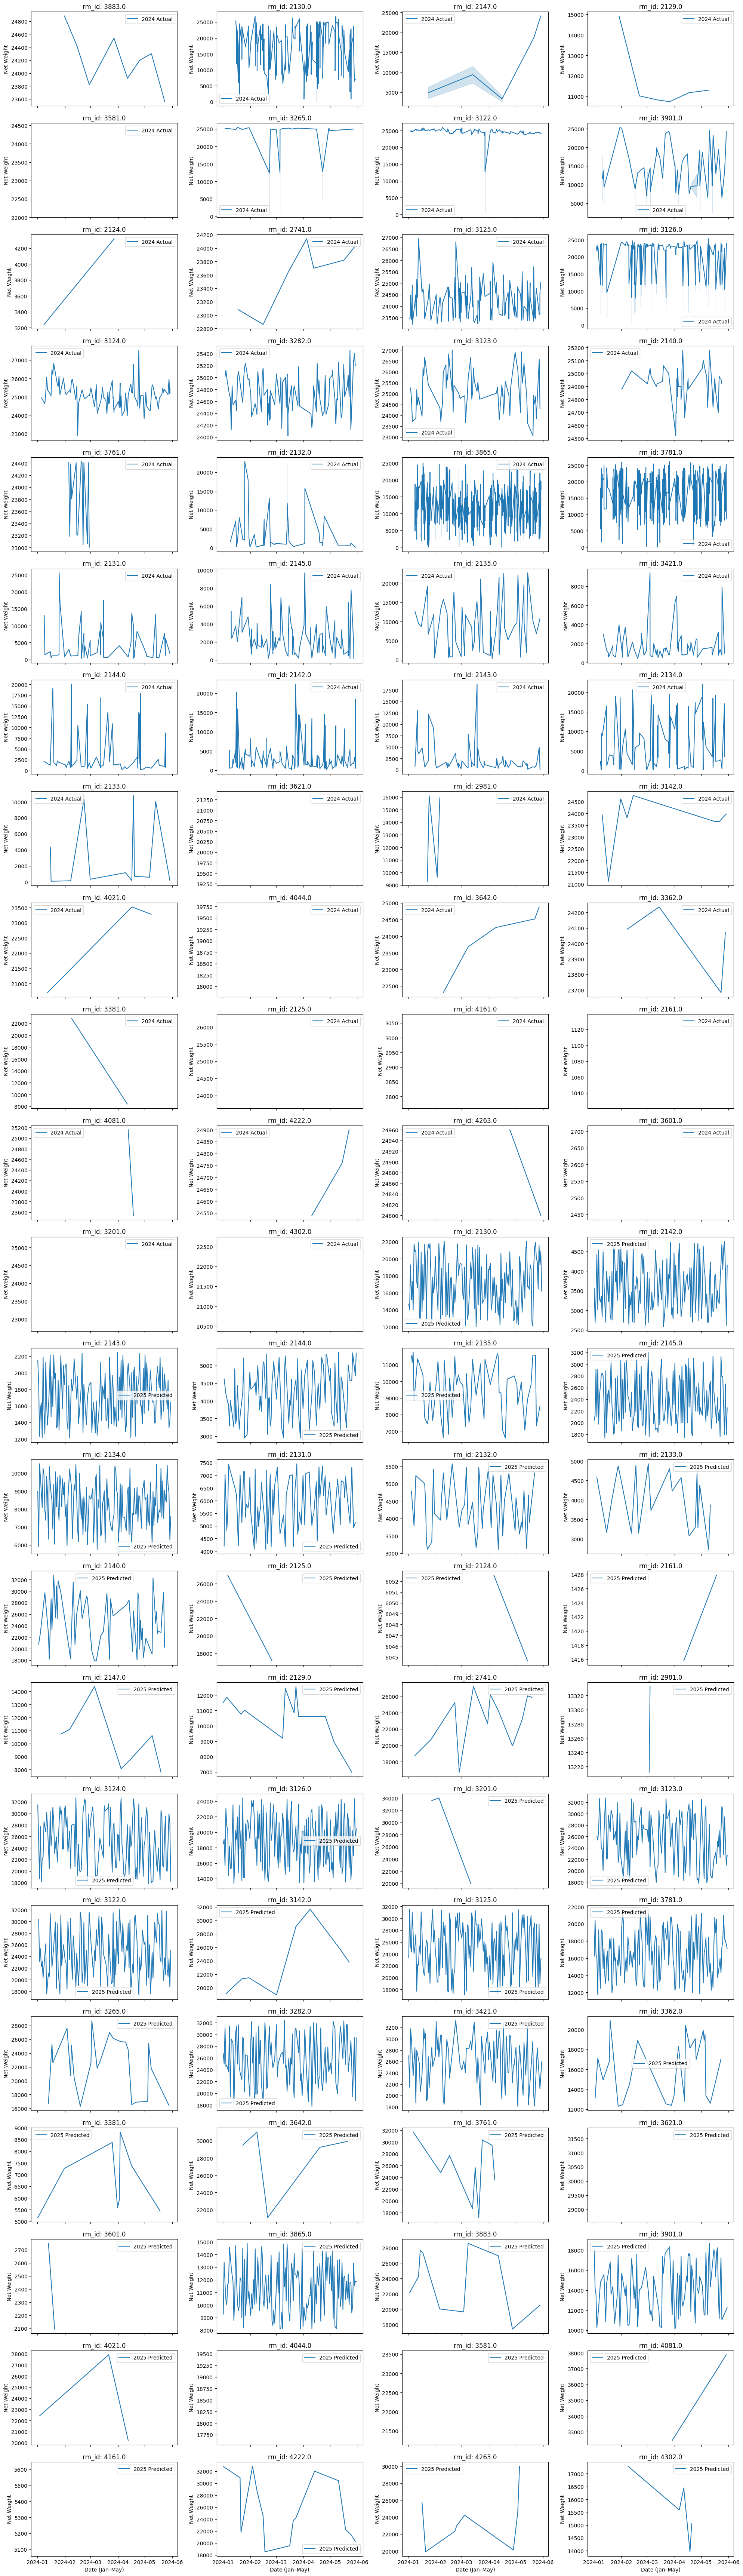

In [81]:
# Visualize 2024 actuals and 2025 predictions in the same 'year' for all rm_ids
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare 2024 Jan–May actuals
jan_may_mask_2024 = (df_hist["date_arrival"] >= pd.Timestamp("2024-01-01")) & (df_hist["date_arrival"] <= pd.Timestamp("2024-05-31"))
actual_2024 = df_hist.loc[jan_may_mask_2024].copy()
actual_2024["year"] = 2024

# Prepare 2025 Jan–May predictions
jan_may_mask_2025 = (simulated_df["date_arrival"] >= pd.Timestamp("2025-01-01")) & (simulated_df["date_arrival"] <= pd.Timestamp("2025-05-31"))
pred_2025 = simulated_df.loc[jan_may_mask_2025].copy()
pred_2025["year"] = 2024  # Map 2025 predictions to 2024 for overlay
pred_2025["date_arrival"] = pred_2025["date_arrival"].apply(lambda d: d.replace(year=2024))

# Combine for plotting
actual_2024["type"] = "2024 Actual"
pred_2025["type"] = "2025 Predicted"
plot_df = pd.concat([actual_2024, pred_2025], ignore_index=True)

# Plot for each rm_id
rm_ids = plot_df["rm_id"].unique()
n_rm = len(rm_ids)
n_cols = 4
n_rows = int(np.ceil(n_rm / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3*n_rows), sharex=True)
axes = axes.flatten()

for i, rm_id in enumerate(rm_ids):
    ax = axes[i]
    df_rm = plot_df[plot_df["rm_id"] == rm_id]
    sns.lineplot(data=df_rm, x="date_arrival", y="net_weight", hue="type", ax=ax)
    ax.set_title(f"rm_id: {rm_id}")
    ax.set_xlabel("Date (Jan–May)")
    ax.set_ylabel("Net Weight")
    ax.legend()

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()